# Lecture overview

- Coverage
    - We only cover "static" models (of the type $y_{t+k} = \alpha + \beta \cdot X_t + \epsilon_{t+k}$)
    - We do not cover dynamic models (e.g. ARIMA models or VAR models which include lags of the dependent variable as explanatory variables)
    - We do not cover conditional heteroskedasticity models (e.g. ARCH and GARCH models of the variance of the error term)
        

- Dealing with autocorrelated errors (failure of assumption A3)
    - Newey-West correction


- Dealing with non-stationary variables (failure of assumption A2)
    - Test for stationarity
    - Common ways to address non-stationarity
        - First-differencing
        - Detrending

## Application

The showcase the tools in this lecture, we will develop a (somewhat crude) test of the Expectations Hypothesis of the term structure of interest rates. In a nutshell, this hypothesis claims long-term rates should equal compounded future expected short-term rates:

$$ (1 + r_{t,t+N})^N = (1 + E_t(r_{t,t+1}))(1 + E_t(r_{t+1,t+2}))...(1 + E_t(r_{t+N-1,t+N})) $$

Assuming rational expectations, future realized short-term rates should on average match current expectations of those rates. If this is the case, one way we can test the Expectations Hypothesis by testing if current long-term rates can predict future short-term rates.

To implement this test, we use the yield on 10-year Treasury bonds as our long-term rate, and the yield on the 3-month Treasury bill as our short-term rate. We then regress the 3-month rate from 5 years in the future on the current 10-year rate 

$$r^{3m}_{t+5} = \alpha + \beta \cdot r^{10yr}_t + \epsilon_{t+5} $$


Yes, the 5-year horizon is quite arbitrary (we should be testing all horizons up to 10 years at the same time), hence my calling it a "somewhat crude" test. The purpose of this application is to showcase the common statistical issues one often encounters in time-series regressions. See this paper https://core.ac.uk/download/pdf/6956537.pdf for more thorough tests of the hypothesis.

We start by downloading data on the two rates (monthly frequency, not seasonally adjusted) and running the regression mentioned above. The rest of the lecture describes two main issues with this regression (non-stationarity and autocorrelated errors) and describes common tools used to address these issues. 

# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import statsmodels.api as sm
import statsmodels.tsa.stattools as st

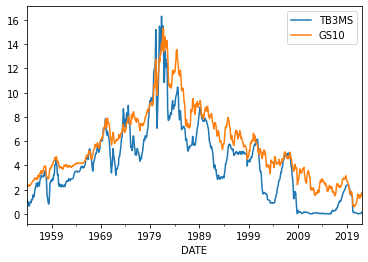

In [2]:
# Download monthly data on 3month and 10yr treasury yields from St Louis FRED
rates = pdr.DataReader(['TB3MS','GS10'],'fred','1954-01-01')
rates.plot();

In [3]:
# Cleanup
    # Change index to montly period
rates.index = rates.index.to_period('M')
    # Rename variables
rates.rename(columns = {'TB3MS': 'r_3m', 'GS10': 'r_10yr'}, inplace = True)
rates    

,r_3m,r_10yr
DATE,,
1954-01,1.18,2.48
1954-02,0.97,2.47
1954-03,1.03,2.37
1954-04,0.97,2.29
1954-05,0.76,2.37
...,...,...
2021-09,0.04,1.37
2021-10,0.05,1.58
2021-11,0.05,1.56


In [4]:
# Calculate future levels of the short rate (m3)
rates['r_3m_lead5'] = rates['r_3m'].shift(-60)      #because 60 months = 5 years
rates

,r_3m,r_10yr,r_3m_lead5
DATE,,,
1954-01,1.18,2.48,2.82
1954-02,0.97,2.47,2.70
1954-03,1.03,2.37,2.80
1954-04,0.97,2.29,2.95
1954-05,0.76,2.37,2.84
...,...,...,...
2021-09,0.04,1.37,NaN
2021-10,0.05,1.58,NaN
2021-11,0.05,1.56,NaN


In [5]:
# Save data for next time
rates.to_pickle('../data/rates.pkl')

# Descriptive statistics

We start by just summarising the data and looking at correlations of the variables. With time-series regressions,we want to pay particular attention to how autocorrelated our variables are. 

In [6]:
rates.describe()

,r_3m,r_10yr,r_3m_lead5
count,817.000000,817.000000,757.000000
mean,4.203684,5.656732,4.373804
std,3.127007,2.928016,3.177423
min,0.010000,0.620000,0.010000
25%,1.720000,3.590000,1.950000
50%,4.020000,5.110000,4.440000
75%,5.770000,7.430000,6.040000
max,16.300000,15.320000,16.300000


In [7]:
rates.corr()

,r_3m,r_10yr,r_3m_lead5
r_3m,1.000000,0.928602,0.579861
r_10yr,0.928602,1.000000,0.585391
r_3m_lead5,0.579861,0.585391,1.000000


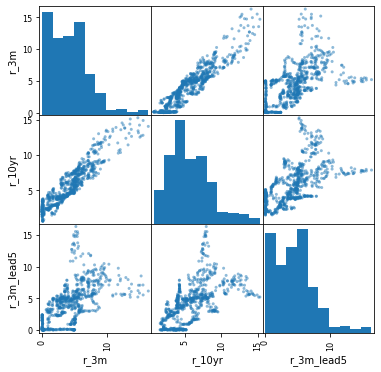

In [8]:
pd.plotting.scatter_matrix(rates, figsize = (6,6));

Always look at autocorrelations in your data before you run a time-series regression:

In [9]:
rates['r_3m'].autocorr()

0.9915536423981736

In [10]:
rates['r_10yr'].autocorr()

0.9959134840414957

The above are just one-period (1 month) autocorrelations. We can look at all autocorrelations (all lags):

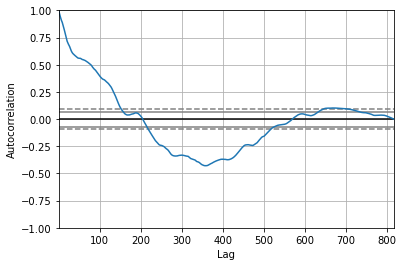

In [11]:
pd.plotting.autocorrelation_plot(rates['r_3m']);

# Linear regression

We start by running the simple regression of future short term rates on current long-term rates:


$$r^{3m}_{t+5} = \alpha + \beta \cdot r^{10yr}_t + \epsilon_{t+5} $$

In [12]:
# Add a constant
rates['const'] = 1

In [13]:
# Regress future short rate on current long rate
results = sm.OLS(rates['r_3m_lead5'], rates[['const','r_10yr']], missing = 'drop').fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             r_3m_lead5   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     393.6
Date:                Fri, 25 Feb 2022   Prob (F-statistic):           8.02e-71
Time:                        14:39:54   Log-Likelihood:                -1790.0
No. Observations:                 757   AIC:                             3584.
Df Residuals:                     755   BIC:                             3593.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4650      0.218      2.131      0.0

The low p-value for the ``r_10yr`` coefficient tells us that the long rate is a strong predictor of the future short rate, which is consistent with the Expectations Hypothesis.

# Dealing with autocorrelated errors

The Durbin-Watson statistic in the regression above is close to 0, which suggests the error terms in our regression are positively autocorrelated. This violates assumption A3 discussed in the regression intro lecture. 

To address this issue, we can apply the "get_robustcov_results" function to the results output from the OLS regression above, specifying that the covariance type ("cov_type") needs to be heteroskedasticity-and-autocorrelation consistent (HAC). We also need to specify the maximum number of lags we want to use when correcting our standar errors (the "maxlag" parameter). This implements the Newey-West (1987) covariance estimator that adjusts standard errors for autocorrelation in residuals up to the "maxlag" you specified. 

In [14]:
# Run the regression without any correction first
results = sm.OLS(rates['r_3m_lead5'], rates[['const','r_10yr']], missing = 'drop').fit()

Most practitioners use $maxlag = N^{1/4}$ where N is the number of observations in our regression (though we will not go into detail about why this value is used).

In [15]:
# N^(1/4)
results.nobs**0.25

5.2453439338517365

In [16]:
# Obtain HAC standard errors
results_hac = results.get_robustcov_results(cov_type = 'HAC', maxlags = 5)
print(results_hac.summary())

                            OLS Regression Results                            
Dep. Variable:             r_3m_lead5   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     71.97
Date:                Fri, 25 Feb 2022   Prob (F-statistic):           1.15e-16
Time:                        14:39:54   Log-Likelihood:                -1790.0
No. Observations:                 757   AIC:                             3584.
Df Residuals:                     755   BIC:                             3593.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4650      0.438      1.063      0.2

Note that this correction does not change the coefficients themselves, just their statistical significance. For example the constant term is no longer statistically significant. More importantly for our application: the long term rate is still a statistically significant predictor of the future short rate, which is consistent with the Expectations Hypothesis.

# Dealing with non-stationarity

A "stationary" time-series process is a process that has a constant mean and variance over time, and autocorrelations depend only on the lag, not on the time period itself (technically speaking, such processes are called "covariance-stationary" or "weakly-stationary" but these are usually shortened to "stationary").

If the variables in our time-series regression are non-stationary, the regression estimates are not reliable because non-stationarity can cause:
- A "spurious correlation" between the two variables (variables may look highly correlated when in fact they are not economically related in any way)
    - This is a failure of assumption A2
    - This leads to a bias in the regression coefficients (affects conclusions on economic significance)
- Heteroskedasticity and autocorrelation in the regression residuals 
    - This is a failure of assumption A3
    - In thise case, t-statistics and p-values will be miscalculated (affects conclusions on statistical significance)



## Testing for stationarity (unit root tests)

Before you run ANY time series regression, you need to first test if the variables in your regression are stationary (such tests are commonly referred to as "unit root tests"). There are several test you could use for this purpose, but one of the most common ones is the Augmented Dickey-Fuller test (ADF). You can implement this test using the "adfuller" function from the "statsmodels.tsa.stattools" package ("st" below).

The null hypothesis in the ADF test is that the series is non-stationary. So if the test returns a small p-value (e.g smaller that 1%), we can conclude that the series does not suffer from non-stationarity. 


In [17]:
# Test if short rate is not stationary
adf_m3 = st.adfuller(rates['r_3m_lead5'].dropna())
print("P-value = ", adf_m3[1])
print("\nAll results:")
adf_m3

P-value =  0.3021083944344449

All results:


(-1.9650413351510605,
 0.3021083944344449,
 20,
 736,
 {'1%': -3.4392661055744767,
  '5%': -2.86547495466493,
  '10%': -2.56886540295664},
 583.7846147439693)

The p-value above is larger than 1\% so we can not conclude that the short rate is non-stationary.

In [18]:
# Test if long rate is not stationary
adf_y10 = st.adfuller(rates['r_10yr'].dropna())
print("P-value = ", adf_y10[1])

P-value =  0.7806902727097635


The p-value above is larger than 1\% so we can not conclude that the long rate is non-stationary.

## First-differencing

The most commonly used method to convert a non-stationary series into a stationary series it to first-difference it (i.e. current level minus the previous level of the series). Technically, this assumes that the non-stationary series has "order of integration 1" which is the case for most economic series of interest. You don't need to understand what that means for this class. I am only mentioning it so you understand that sometimes, first-differencing may NOT produce a stationary series. In such cases, a second-difference may help: take a first-difference of the first-difference. Alternatively, use the detrending methods in sections 3.3. and 3.4. below.   

In [19]:
# Calculate first diferences
rates['r_3m_change'] = rates['r_3m_lead5'].diff()
rates['r_10yr_change'] = rates['r_10yr'].diff()

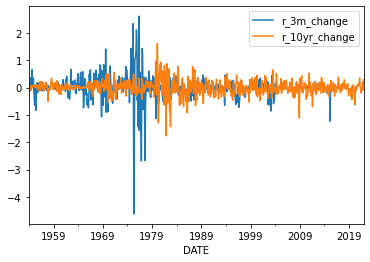

In [20]:
# Take a look at the differenced series
rates[['r_3m_change','r_10yr_change']].plot();
rates.dropna(inplace = True)

In [21]:
# Look at autocorrelation of differenced short rate
rates['r_3m_change'].autocorr()

0.3301913374751896

It looks like the 1-month autocorrelation is still quite high. But, if we look at the autocorrelation plot (the gray lines are 95\% confidence intervals), most of these autocorrelations are statistically insignificant. 

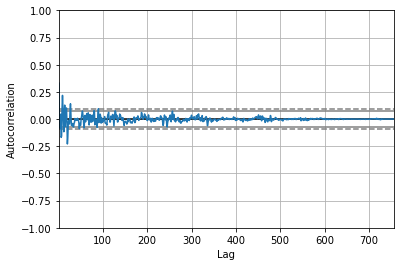

In [22]:
pd.plotting.autocorrelation_plot(rates['r_3m_change']);

Again, to formally test if we still have a non-stationary problem, we run a ADF test:

In [23]:
# Test if differenced short rate is non-stationary
adf_m3 = st.adfuller(rates['r_3m_change'].dropna())
print("P-value = ", adf_m3[1])

P-value =  4.8474710656084215e-08


The p-value is virtually 0, so we can reject the null of non-stationarity for the first-differenced short rate.

In [24]:
# Test if differenced long rate is non-stationary
adf_y10 = st.adfuller(rates['r_10yr_change'].dropna())
print("P-value = ", adf_y10[1])

P-value =  1.617988023356004e-11


Again, the p-value is virtually 0, so we can reject the null of non-stationarity for the first-differenced long rate too.

In [25]:
# Re-run regression using differenced variables 
results = sm.OLS(rates['r_3m_change'], rates[['const','r_10yr_change']], missing='drop').fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            r_3m_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.099
Date:                Fri, 25 Feb 2022   Prob (F-statistic):              0.295
Time:                        14:39:54   Log-Likelihood:                -408.69
No. Observations:                 756   AIC:                             821.4
Df Residuals:                     754   BIC:                             830.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0035      0.015     -0.233

In [26]:
# Obtain HAC standard errors
results_hac = results.get_robustcov_results(cov_type = 'HAC', maxlags = 5)
print(results_hac.summary())

                            OLS Regression Results                            
Dep. Variable:            r_3m_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.9896
Date:                Fri, 25 Feb 2022   Prob (F-statistic):              0.320
Time:                        14:39:54   Log-Likelihood:                -408.69
No. Observations:                 756   AIC:                             821.4
Df Residuals:                     754   BIC:                             830.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0035      0.018     -0.199

These results differ from the non-differenced regression in a very crucial way: the p-value of the ``r_10yr_change`` variable is not lower than 1\% anymore, so we can not reject the null that the long rate has no predictive power over the short rate. This **contradicts** the prediction of the Expectations Hypothesis that long rates should have statistically significant predictive power over short rates.

## Controlling for deterministic trends

If we believe that our variables are non-stationary because of a deterministic trend (like a linear trend or a quadratic trend), then we can adjust for this by simply including these trends in our regression. To do this, we first create the trend variables (we will restrict ourselves to a linear trend and a quadratic trend), and then we simply add them to our regression. 

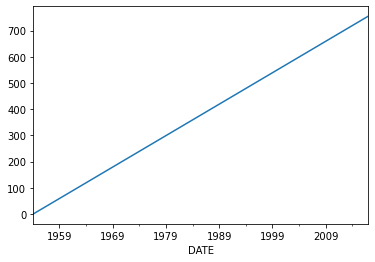

In [27]:
# Create linear and quadratic trends
rates['linear_trend'] = range(rates['r_3m_lead5'].count())
rates['linear_trend'].plot();

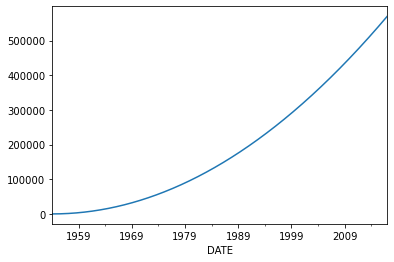

In [28]:
rates['quadratic_trend'] = rates['linear_trend']**2
rates['quadratic_trend'].plot();

In [29]:
# Control for trends in our main regression directly
results = sm.OLS(rates['r_3m_lead5'], 
                 rates[['const','r_10yr','linear_trend','quadratic_trend']], missing='drop'
                ).fit().get_robustcov_results(cov_type = 'HAC', maxlags = 5)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             r_3m_lead5   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     58.47
Date:                Fri, 25 Feb 2022   Prob (F-statistic):           5.57e-34
Time:                        14:39:54   Log-Likelihood:                -1623.3
No. Observations:                 756   AIC:                             3255.
Df Residuals:                     752   BIC:                             3273.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.9522      0.348     

Note that even controlling for trends renders the long-rate statistically insignificant. 

## Eliminating stochastic (changing) trends (OPTIONAL)

In some cases, non-stationarity could be caused by trends that change over time (e.g. a linear trend in the first part of the sample,  no trend in the middle, and a quadratic trend towards the end). In this case, the deterministic-trends approach from above may not accurately control for these trends and hence may not solve our non-stationarity problem.

In this circumstance, it is more appropriate to estimate these stochastic trends first (for each series). Then subtract these trends from the series and use these de-trended variables in our regression instead. 
The **Hodrick-Prescott method** is very commonly used for this purpose and it outputs the detrended series directly (as well as the estimated trend). This method can be implemented using the ``.tsa.filters.hpfilter()`` function in the ``statsmodel`` package, as below. 

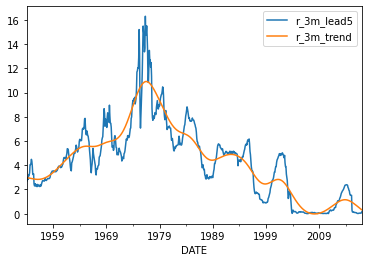

In [30]:
# Estimate stochastic trend in short rate using Hodrick-Prescott method
rates['r_3m_detrended'],rates['r_3m_trend'] = sm.tsa.filters.hpfilter(rates['r_3m_lead5'],lamb = 129600)
        #IMPORTANT: we use this "lamb" value because we have monthly data. 
        #use lamb = 1600 for quarterly data and lamb = 6.25 for annual data
        
# Take a look at the short rate and its stochastic trend
rates[['r_3m_lead5','r_3m_trend']].plot(); 

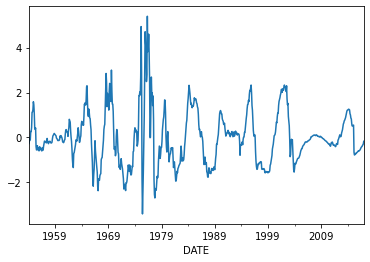

In [31]:
# Now take a look at the detrended short rate
rates['r_3m_detrended'].plot(); 

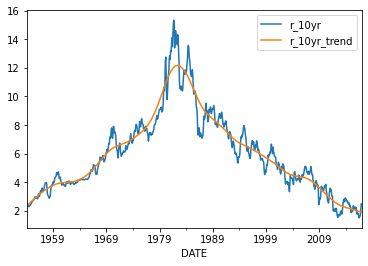

In [32]:
# Estimate stochastic trend in long rate using Hodrick-Prescott method
rates['r_10yr_detrended'],rates['r_10yr_trend'] = sm.tsa.filters.hpfilter(rates['r_10yr'],lamb = 129600)

# Take a look at the results 
rates[['r_10yr','r_10yr_trend']].plot(); 

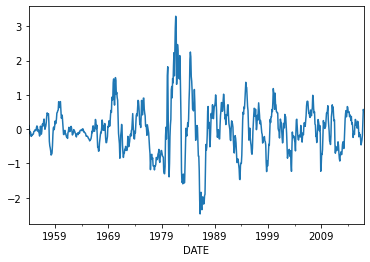

In [33]:
# Now take a look at the detrended long rate
rates['r_10yr_detrended'].plot(); 

In [34]:
# Re-run regression using detrended series
results = sm.OLS(rates['r_3m_detrended'], 
                 rates[['const','r_10yr_detrended']], missing='drop'
                ).fit().get_robustcov_results(cov_type = 'HAC', maxlags = 5)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         r_3m_detrended   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                    0.8779
Date:                Fri, 25 Feb 2022   Prob (F-statistic):              0.349
Time:                        14:39:55   Log-Likelihood:                -1201.4
No. Observations:                 756   AIC:                             2407.
Df Residuals:                     754   BIC:                             2416.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              5.36e-12      0.097  

Once again, detrending the data using stochastic trends also renders the long rate insignificant. 